In [ ]:
import cpuinfo
if "Intel" in cpuinfo.get_cpu_info()['brand_raw']:
    from sklearnex import patch_sklearn
    patch_sklearn()

In [1]:
import os
os.chdir("..")

In [2]:
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
SAMPLE_SIZE = 500
root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/train"
mel_imgs = np.random.choice(list((chall1/'mel').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
bcc_imgs = np.random.choice(list((chall1/'bcc').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
scc_imgs = np.random.choice(list((chall1/'scc').glob("*inpaint_0_5.png")), SAMPLE_SIZE)

test_imgs = np.concatenate([mel_imgs, bcc_imgs, scc_imgs])

brisk = cv2.BRISK_create(thresh=30, octaves=0)


color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'lab':cv2.COLOR_RGB2LAB,  'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius


dense_brisk_color = ColorDescriptor(brisk, color_spaces, meanshift=mshift_params,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25)

dense_brisk = DenseDescriptor(descriptor=brisk, min_keypoints=100, max_keypoints=500, kp_size=10)


In [4]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls)

descriptors = []
img_classes = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)

100%|██████████| 1500/1500 [01:06<00:00, 22.58it/s]


In [9]:
descriptors_color = []
img_classes_color = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)

  0%|          | 0/1500 [00:00<?, ?it/s]/home/vzalevskyi/anaconda3/envs/dev/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 1500/1500 [15:10<00:00,  1.65it/s] 


In [9]:
# # BRISK doesnt output a stable number of keypoints after .compute()
# _load_and_extract_des((test_imgs[10], dense_brisk))[0].shape

In [10]:
pd.to_pickle((descriptors_color, img_classes_color), 'descriptors_color_3cls.pkl')
pd.to_pickle((descriptors, img_classes), 'descriptors_brisk_3cls.pkl')
# descriptors, img_classes = pd.read_pickle('descriptors.pkl')

1500 500 64


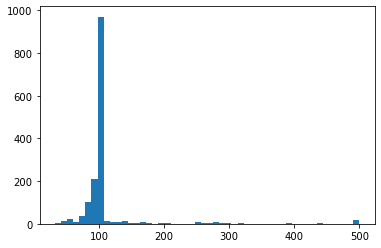

In [11]:
print(len(descriptors), len(descriptors_color[0]), len(descriptors[0][0]))
plt.hist([len(d) for d in descriptors], bins=50)
plt.show()

1500 500 96


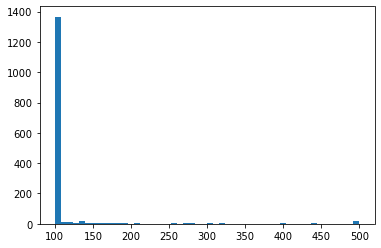

In [12]:
print(len(descriptors_color), len(descriptors_color[0]), len(descriptors_color[0][0]))
plt.hist([len(d) for d in descriptors_color], bins=50)
plt.show()

Brisk Dense

In [8]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, img_classes, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000, class_weight='balanced', random_state=42)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.47      0.56      0.51       158
           1       0.56      0.56      0.56       163
           2       0.53      0.44      0.48       174

    accuracy                           0.52       495
   macro avg       0.52      0.52      0.51       495
weighted avg       0.52      0.52      0.51       495

Accuracy: 0.5151515151515151

Confusion Matrix: 
[[88 38 32]
 [37 91 35]
 [64 34 76]]


Color descriptors

In [13]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_color, img_classes_color, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000, class_weight='balanced', random_state=42)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       158
           1       0.74      0.77      0.75       163
           2       0.69      0.64      0.66       174

    accuracy                           0.67       495
   macro avg       0.67      0.67      0.67       495
weighted avg       0.67      0.67      0.67       495

Accuracy: 0.6686868686868687

Confusion Matrix: 
[[ 95  26  37]
 [ 24 125  14]
 [ 44  19 111]]


Pure color features

In [17]:
proc_data = Path().resolve() / 'data/processed'
chl = 'chall2'
mode = 'train'
feat_type = 'raw'


test_path = proc_data / f'{chl}/{mode}'
print('\nAnalyzing features for', feat_type)

bcc_data = pd.read_feather(test_path / f'bcc_color_features_{feat_type}_full_image.feather').set_index('name')
bcc_data['class'] = 0

mel_data = pd.read_feather(test_path/ f'mel_color_features_{feat_type}_full_image.feather').set_index('name')
mel_data['class'] = 1

scc_data = pd.read_feather(test_path/ f'scc_color_features_{feat_type}_full_image.feather').set_index('name')
scc_data['class'] = 2

data = pd.concat([scc_data, bcc_data, mel_data])

current_test_data = data.loc[[str(x.name).split('_')[0] for x in test_imgs]]
current_test_data


Analyzing features for raw


,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,class
name,,,,,,,,,,,,,,,,,,,,,
mel01182,110.425674,53.875633,-0.283627,-1.137500,224.0,0.0,12.334336,224,96.589661,45.113319,...,10281,4.621872,7.421074,0.380446,-0.100068,33.093559,-26.308046,-inf,10281,1
mel02214,164.801849,38.928581,-1.195871,0.511550,209.0,28.0,12.444675,182,151.469940,48.811367,...,4261,8.278458,7.719588,0.717642,-0.527988,33.211437,-7.863562,-inf,4261,1
mel02013,176.847778,25.059723,-1.946485,3.286428,208.0,69.0,11.108628,140,141.311966,33.076290,...,2978,18.872868,5.644355,1.743642,2.239694,41.362926,5.634658,11.080506,2833,1
mel01513,177.357605,16.567038,-3.485138,22.561472,204.0,3.0,12.471473,202,130.194672,27.101379,...,8927,21.745251,9.241620,-0.243032,-0.400233,47.922249,-6.576507,-inf,8927,1
mel00439,115.918289,30.214756,-2.889763,7.401028,138.0,0.0,12.420662,139,113.630135,30.931532,...,2046,1.799402,4.692972,2.510505,6.788339,22.873882,-9.344057,-inf,2046,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00284,187.388977,22.337431,-0.266379,-0.398548,235.0,89.0,12.469422,146,173.109924,21.413519,...,4226,6.536282,5.801471,0.365279,-0.499392,28.477222,-11.186649,-inf,4226,2
scc00347,215.878601,18.361780,-4.164833,23.964413,236.0,48.0,11.115647,189,190.918701,23.838171,...,1630,13.935909,4.237476,3.542602,15.968687,41.375336,7.658289,11.083048,1556,2
scc00315,62.325752,91.949753,0.933309,-0.989055,242.0,0.0,11.383615,243,53.211441,78.936127,...,4710,4.710019,6.645122,1.226203,0.135813,33.305626,-0.830476,-inf,4707,2


In [18]:

all_X = current_test_data.drop(columns=['class']).values
all_y = current_test_data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.54      0.66      0.59       141
           1       0.80      0.77      0.79       148
           2       0.63      0.53      0.58       161

    accuracy                           0.65       450
   macro avg       0.66      0.65      0.65       450
weighted avg       0.66      0.65      0.65       450

Accuracy: 0.6511111111111111

Confusion Matrix: 
[[ 93  12  36]
 [ 20 114  14]
 [ 59  16  86]]
